# Setup


In [13]:
import os
import time
import sys

import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow.keras import (
    Sequential,
    layers,
    optimizers,
    regularizers,
    callbacks,
    losses,
)
import tensorflow_hub as hub


In [17]:
functions_path = os.path.join("..", "..", "..", "functions")

sys.path.append(functions_path)

import learning_rate_functions


In [35]:
print(f"TensorFlow version:{tf.version.VERSION}")

device_name = tf.test.gpu_device_name()

if device_name == "":
    raise SystemError("\tNo GPU detected!")
else:
    print(f"\tGPU -> {device_name}")


TensorFlow version:2.8.0
	GPU -> /device:GPU:0


In [36]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "COMPRESSED"


# Helper Functions


In [18]:
def get_logdir(format="full"):
    run_id = time.strftime("run_%Y%m%d-%H%M%S")
    logdir = os.path.join("..", "..", "reports", "logs", logdir)
    return logdir


# Constants


In [31]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
CLASS_NAMES = "daisy dandelion roses sunflowers tulips".split()
BATCH_SIZE = 32 if device_name == "" else 512

MODEL_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
TRAIN_URL = "gs://practical-ml-vision-book/flowers_tfr/train-*"
VALID_URL = "gs://practical-ml-vision-book/flowers_tfr/valid-*"
IMAGES_LIST = [
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/98992760_53ed1d26a9.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9939430464_5f5861ebab.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9965757055_ff01b5ee6f_n.jpg",
]


# Preprocessor


In [27]:
class _Preprocessor:
    def __init__(self):
        pass

    def read_from_tfr(self, proto):
        feature_description = {
            "image": tf.io.VarLenFeature(tf.float32),
            "shape": tf.io.VarLenFeature(tf.int64),
            "label": tf.io.FixedLenFeature([], tf.string, default_value=""),
            "label_int": tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }

        record = tf.io.parse_single_example(proto, feature_description)
        shape = tf.sparse.to_dense(record["shape"])
        image = tf.reshape(tf.sparse.to_dense(record["image"]), shape)
        label_int = record["label_int"]
        return image, label_int

    def read_from_jpegfile(self, filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=IMG_CHANNELS)
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image

    def preprocess(self, img):
        return tf.image.resize_with_pad(img, 2 * IMG_HEIGHT, 2 * IMG_WIDTH)


In [28]:
def create_preproc_dataset(pattern):
    preprocessor = _Preprocessor()
    dataset = (
        tf.data.TFRecordDataset(
            [file for file in tf.io.gfile.glob(pattern)], compression_type="GZIP"
        )
        .map(preprocessor.read_from_tfr)
        .map(lambda image, label: (preprocessor.preprocess(image), label))
    )
    return dataset


def create_preproc_image(filename):
    preprocessor = _Preprocessor()
    img = preprocessor.read_from_jpegfile(filename)
    img = preprocessor.preprocess(img)
    return img


Let's test the `Preprocessor` with TFRecords:


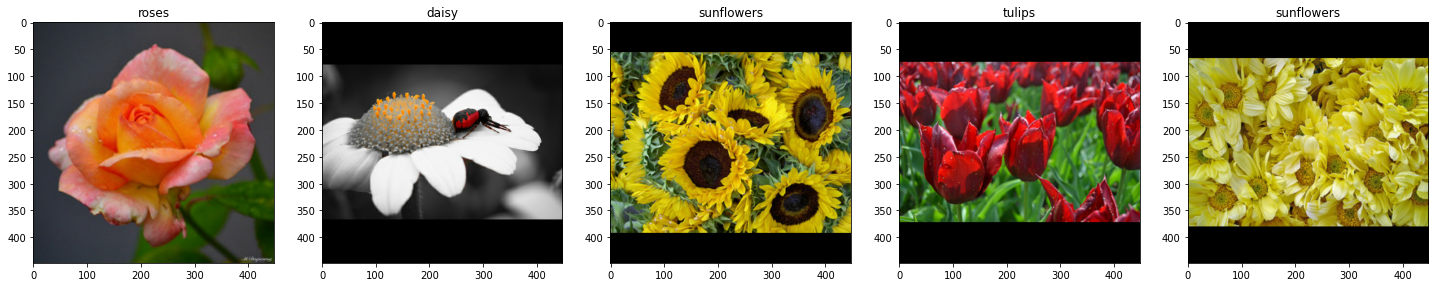

In [32]:
train_dataset = create_preproc_dataset(TRAIN_URL)
_, ax = plt.subplots(1, 5, figsize=(25, 15))
for idx, (image, label) in enumerate(train_dataset.shuffle(1000).take(5)):
    ax[idx].imshow((image.numpy()))
    ax[idx].set_title(CLASS_NAMES[label.numpy()])


Let's now see for individual files:


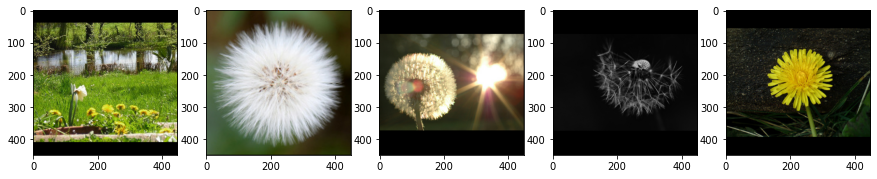

In [33]:
input_images = [create_preproc_image(file) for file in IMAGES_LIST]

_, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, image in enumerate(input_images):
    ax[idx].imshow((image.numpy()))


# Transfer Learning with MobileNet


In [ ]:
def train_and_evaluate(lrate=0.001, l1=0.0, l2=0.0, num_hidden=16):
    regularizer = regularizers.l1_l2(l1, l2)

    train_dataset = create_preproc_dataset(TRAIN_URL).batch(BATCH_SIZE)
    valid_dataset = create_preproc_dataset(VALID_URL).batch(BATCH_SIZE)

    layers_list = [
        layers.CenterCrop(
            height=IMG_HEIGHT,
            width=IMG_WIDTH,
            input_shape=(2 * IMG_HEIGHT, 2 * IMG_WIDTH, IMG_CHANNELS),
        ),
        hub.KerasLayer(MODEL_URL, trainable=False, name="mobilenet_embedding"),
        layers.Dense(
            num_hidden,
            kernel_regularizer=regularizer,
            kernel_initializer="he_normal",
            activation="elu",
            name="dense_hidden",
        ),
        layers.Dense(
            len(CLASS_NAMES),
            kernel_regularizer=regularizer,
            activation='softmax',
            name='flower_prob'
        )
    ]
    
    model = Sequential(layers_list, name='flower_classification')
    model.compile(
        optimizer = optimizers.Adam()
    )
